In [1]:
import numpy as np
import pandas as pd

from Datasets.utk_face import UTKFaceDataset

#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create the dataloader
dataloader = torch.utils.data.DataLoader(UTKFaceDataset(), batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

torch.Size([128, 3, 200, 200])


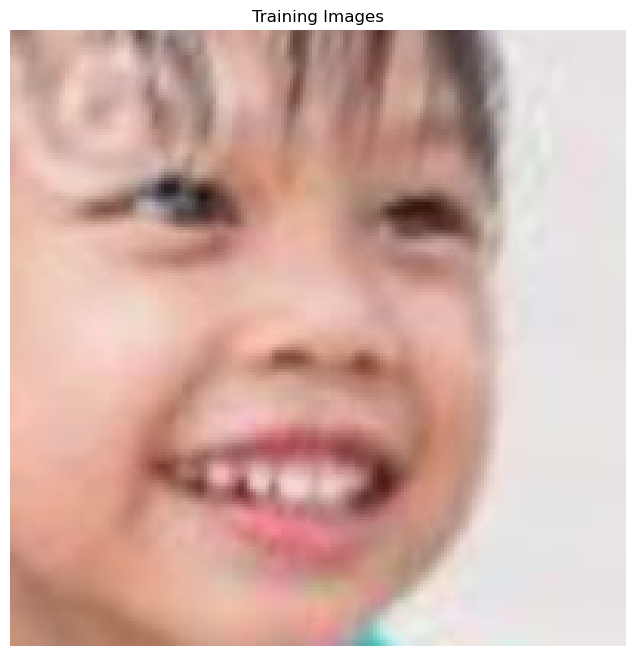

In [4]:
# Plot some training images
real_batch, label = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(real_batch.shape)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

In [15]:
class Encoder(nn.Module):
    def __init__(self, z):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 8, 4)
        self.conv3 = nn.Conv2d(8, 4, 5, stride=2)
        self.fc1 = nn.Linear(36864, 64)
        self.fc2 = nn.Linear(64, z)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, z):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(16, 3, 3)
        self.conv2 = nn.ConvTranspose2d(8, 16, 4)
        self.conv3 = nn.ConvTranspose2d(4, 8, 5, stride=2)
        self.fc1 = nn.Linear(64, 36864)
        self.fc2 = nn.Linear(z, 64)

    def forward(self, x):
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc1(x)
        x = x.reshape(batch_size, 4, 96, 96)

        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv1(x)
        
        return x
    

class Autoencoder(nn.Module):
    def __init__(self, z):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(z)
        self.decoder = Decoder(z)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [16]:
model = Autoencoder(32)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
history = []

train_batches = 10
valid_batches = 2
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    total_train_loss = 0
    for batch in range(train_batches):
        images, labels = next(data_iter)

        images = images.to(device)

        optimizer.zero_grad()

        recon = model(images)

        loss = criterion(images, recon)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_size
    
    train_loss = total_train_loss / (batch_size * train_batches)
    print("Train loss:", train_loss)

    total_valid_loss = 0
    for batch in range(train_batches, train_batches+valid_batches):
        images, labels = next(data_iter)

        images = images.to(device)

        recon = model(images)

        loss = criterion(images, recon)

        total_valid_loss += loss.item() * batch_size

    valid_loss = total_valid_loss / (batch_size * valid_batches)
    print("Valid loss:", valid_loss)

    history.append((train_loss, valid_loss))
    

Train loss: 0.11030417889356613
Valid loss: 0.052377859503030776


KeyboardInterrupt: 